In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from mlp.data_providers import CIFAR100DataProvider
%matplotlib inline

In [2]:
train_data = CIFAR100DataProvider('train',batch_size=50)
valid_data = CIFAR100DataProvider('valid',batch_size=50)

(-0.5, 31.5, 31.5, -0.5)

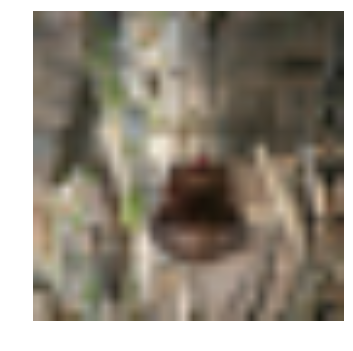

In [3]:
get_images = train_data.next()[0]
image = get_images[11].reshape((32,32,3),order='F')
plt.imshow(image)
plt.axis('off')

In [4]:
#Experiments all epoch 60. batch size 50

#2. Regularization
err_l101_train = []
err_l101_valid = []
err_l201_train = []
err_l201_valid = []
err_l1001_train = []
err_l1001_valid = []
err_l2001_train = []
err_l2001_valid = []


acc_l101_train = []
acc_l101_valid = []
acc_l201_train = []
acc_l201_valid = []
acc_l101_train = []
acc_l1001_valid = []
acc_l2001_train = []
acc_l2001_valid = []

In [5]:
graph_l101 = tf.Graph()
graph_l201 = tf.Graph()
graph_l1001 = tf.Graph()
graph_l2001 = tf.Graph()

In [6]:
def plot_graph(err_train,acc_train,err_valid,acc_valid,name="Graph"):
    path='./graphs/'+name
    val_epoch=range(5,105,5)
    err_epoch=range(1,101,1)
    plt.grid()
    plt.plot(err_epoch,err_train,'-b+',label='Train Error')
    plt.plot(val_epoch,err_valid,'-ro',label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.savefig(path+'_error.png')
    #plt.show()
    plt.close()
    plt.grid()
    plt.plot(err_epoch,acc_train,'-b+',label='Train Accuracy')
    plt.plot(val_epoch,acc_valid,'-ro',label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.savefig(path+'_accuracy.png')
    #plt.show()
    plt.close()    

In [7]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return weights,outputs

In [8]:
def run_graph(custom_graph=None):
    num_epochs=100
    err_train=[]
    err_valid=[]
    acc_train=[]
    acc_valid=[]
    if custom_graph=="None":
        print "ERROR: Computation Graph not found"
    with tf.Session(graph=custom_graph) as sess:
        sess.run(init)
        for e in range(num_epochs):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            err_train.append(running_error)
            acc_train.append(running_accuracy)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))
            if (e + 1) % 5 == 0:
                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                err_valid.append(valid_error)
                acc_valid.append(valid_accuracy)
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                       .format(valid_error, valid_accuracy))
        return err_train,acc_train,err_valid,acc_valid


## Begin regularization

In [9]:
#l1 Regularization beta = 0.01
#http://stackoverflow.com/questions/38286717/tensorflow-regularization-with-l2-loss-how-to-apply-to-all-weights-not-just
with graph_l101.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
        beta = 0.01
    with tf.name_scope('fc-layer-3'):
        w1,hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        w2,hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        w3,hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        w4,outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))+beta*(tf.reduce_mean(tf.abs(w1))+
                                                                                                tf.reduce_mean(tf.abs(w2))+
                                                                                                tf.reduce_mean(tf.abs(w3))+
                                                                                                tf.reduce_mean(tf.abs(w4))))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    init = tf.global_variables_initializer()
start = time.time()
err_l101_train,acc_l101_train,err_l101_valid,acc_l101_valid = run_graph(graph_l101)
print("Time taken: %f"%(time.time()-start))


End of epoch 01: err(train)=4.12 acc(train)=0.07
End of epoch 02: err(train)=3.74 acc(train)=0.13
End of epoch 03: err(train)=3.59 acc(train)=0.15
End of epoch 04: err(train)=3.49 acc(train)=0.17
End of epoch 05: err(train)=3.40 acc(train)=0.18
                 err(valid)=3.47 acc(valid)=0.18
End of epoch 06: err(train)=3.33 acc(train)=0.20
End of epoch 07: err(train)=3.27 acc(train)=0.20
End of epoch 08: err(train)=3.20 acc(train)=0.22
End of epoch 09: err(train)=3.15 acc(train)=0.23
End of epoch 10: err(train)=3.10 acc(train)=0.23
                 err(valid)=3.38 acc(valid)=0.20
End of epoch 11: err(train)=3.06 acc(train)=0.24
End of epoch 12: err(train)=3.03 acc(train)=0.25
End of epoch 13: err(train)=2.99 acc(train)=0.25
End of epoch 14: err(train)=2.95 acc(train)=0.26
End of epoch 15: err(train)=2.91 acc(train)=0.27
                 err(valid)=3.39 acc(valid)=0.21
End of epoch 16: err(train)=2.88 acc(train)=0.27
End of epoch 17: err(train)=2.84 acc(train)=0.28
End of epoch 18: err

In [12]:
#l1 Regularization beta = 0.001
#http://stackoverflow.com/questions/38286717/tensorflow-regularization-with-l2-loss-how-to-apply-to-all-weights-not-just
with graph_l1001.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
        beta = 0.001
    with tf.name_scope('fc-layer-3'):
        w1,hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        w2,hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        w3,hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        w4,outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
         error = tf.reduce_mean(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))+beta*(tf.reduce_mean(tf.abs(w1))+
                                                                                                tf.reduce_mean(tf.abs(w2))+
                                                                                                tf.reduce_mean(tf.abs(w3))+
                                                                                                tf.reduce_mean(tf.abs(w4))))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    init = tf.global_variables_initializer()
start = time.time()
err_l1001_train,acc_l1001_train,err_l1001_valid,acc_l1001_valid = run_graph(graph_l1001)
print("Time taken: %f"%(time.time()-start))


End of epoch 01: err(train)=1.90 acc(train)=0.31
End of epoch 02: err(train)=1.71 acc(train)=0.38
End of epoch 03: err(train)=1.63 acc(train)=0.42
End of epoch 04: err(train)=1.57 acc(train)=0.43
End of epoch 05: err(train)=1.53 acc(train)=0.45
                 err(valid)=1.57 acc(valid)=0.44
End of epoch 06: err(train)=1.49 acc(train)=0.47
End of epoch 07: err(train)=1.46 acc(train)=0.48
End of epoch 08: err(train)=1.43 acc(train)=0.49
End of epoch 09: err(train)=1.41 acc(train)=0.50
End of epoch 10: err(train)=1.38 acc(train)=0.50
                 err(valid)=1.54 acc(valid)=0.46
End of epoch 11: err(train)=1.36 acc(train)=0.51
End of epoch 12: err(train)=1.34 acc(train)=0.52
End of epoch 13: err(train)=1.31 acc(train)=0.53
End of epoch 14: err(train)=1.30 acc(train)=0.54
End of epoch 15: err(train)=1.27 acc(train)=0.55
                 err(valid)=1.49 acc(valid)=0.49
End of epoch 16: err(train)=1.26 acc(train)=0.55
End of epoch 17: err(train)=1.24 acc(train)=0.56
End of epoch 18: err

In [10]:
#l2 Regularization beta = 0.01
#http://stackoverflow.com/questions/38286717/tensorflow-regularization-with-l2-loss-how-to-apply-to-all-weights-not-just
with graph_l201.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
        beta = 0.01
    with tf.name_scope('fc-layer-3'):
        w1,hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        w2,hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        w3,hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        w4,outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) +tf.reduce_mean(beta*(tf.nn.l2_loss(w1)+tf.nn.l2_loss(w2)+tf.nn.l2_loss(w3)+tf.nn.l2_loss(w4)))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    init = tf.global_variables_initializer()
start = time.time()
err_l201_train,acc_l201_train,err_l201_valid,acc_l201_valid = run_graph(graph_l201)
print("Time taken: %f"%(time.time()-start))


End of epoch 01: err(train)=5.28 acc(train)=0.06
End of epoch 02: err(train)=4.23 acc(train)=0.09
End of epoch 03: err(train)=4.15 acc(train)=0.10
End of epoch 04: err(train)=4.10 acc(train)=0.11
End of epoch 05: err(train)=4.09 acc(train)=0.11
                 err(valid)=4.13 acc(valid)=0.11
End of epoch 06: err(train)=4.06 acc(train)=0.12
End of epoch 07: err(train)=4.05 acc(train)=0.12
End of epoch 08: err(train)=4.04 acc(train)=0.13
End of epoch 09: err(train)=4.03 acc(train)=0.12
End of epoch 10: err(train)=4.02 acc(train)=0.13
                 err(valid)=3.98 acc(valid)=0.13
End of epoch 11: err(train)=4.02 acc(train)=0.13
End of epoch 12: err(train)=4.02 acc(train)=0.13
End of epoch 13: err(train)=4.01 acc(train)=0.13
End of epoch 14: err(train)=4.00 acc(train)=0.13
End of epoch 15: err(train)=4.00 acc(train)=0.13
                 err(valid)=3.97 acc(valid)=0.14
End of epoch 16: err(train)=3.99 acc(train)=0.14
End of epoch 17: err(train)=3.99 acc(train)=0.14
End of epoch 18: err

In [ ]:
#l2 Regularization beta = 0.001
#http://stackoverflow.com/questions/38286717/tensorflow-regularization-with-l2-loss-how-to-apply-to-all-weights-not-just
with graph_l2001.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
        beta = 0.001
    with tf.name_scope('fc-layer-3'):
        w1,hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        w2,hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        w3,hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        w4,outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + tf.reduce_mean(beta*(tf.nn.l2_loss(w1)+tf.nn.l2_loss(w2)+tf.nn.l2_loss(w3)+tf.nn.l2_loss(w4)))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    init = tf.global_variables_initializer()
start = time.time()
err_l2001_train,acc_l2001_train,err_l2001_valid,acc_l2001_valid = run_graph(graph_l2001)
print("Time taken: %f"%(time.time()-start))


End of epoch 01: err(train)=2.18 acc(train)=0.32
End of epoch 02: err(train)=1.86 acc(train)=0.39
End of epoch 03: err(train)=1.77 acc(train)=0.41


In [11]:
f = open('./log_100/Regularization.csv', 'w' )
f.write( time.ctime(int(time.time()))+'\nLayers,'+'err_train,'+'acc_train,'+'err_valid,'+'acc_valid'+'\n'+
'l101,'+
repr(err_l101_train)+','+
repr(acc_l101_train)+','+
repr(err_l101_valid)+','+
repr(acc_l101_valid)+'\n'+
'l1001,'+
repr(err_l1001_train)+','+
repr(acc_l1001_train)+','+
repr(err_l1001_valid)+','+
repr(acc_l1001_valid)+'\n'+
'l201,'+
repr(err_l201_train)+','+
repr(acc_l201_train)+','+
repr(err_l201_valid)+','+
repr(acc_l201_valid)+'\n'+
'l2001,'+
repr(err_l2001_train)+','+
repr(acc_l2001_train)+','+
repr(err_l2001_valid)+','+
repr(acc_l2001_valid)+'\n')
f.close()

NameError: name 'acc_l1001_train' is not defined

In [12]:
def plot_graph(err_train,acc_train,err_valid,acc_valid,name="Graph"):
    path='./graphs_100/'+name
    val_epoch=range(5,105,5)
    err_epoch=range(1,101,1)
    plt.grid()
    plt.plot(err_epoch,err_train,'-b+',label='Train Error')
    plt.plot(val_epoch,err_valid,'-ro',label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.savefig(path+'_error.png')
    #plt.show()
    plt.close()
    plt.grid()
    plt.plot(err_epoch,acc_train,'-b+',label='Train Accuracy')
    plt.plot(val_epoch,acc_valid,'-ro',label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.savefig(path+'_accuracy.png')
    #plt.show()
    plt.close()    

In [13]:
plot_graph(err_l101_train,acc_l101_train,err_l101_valid,acc_l101_valid,'Regularization_l101')
#plot_graph(err_l1001_train,acc_l1001_train,err_l1001_valid,acc_l1001_valid,'Regularization_l1001')
plot_graph(err_l201_train,acc_l201_train,err_l201_valid,acc_l201_valid,'Regularization_l201')
#plot_graph(err_l2001_train,acc_l2001_train,err_l2001_valid,acc_l2001_valid,'Regularization_l2001')

In [ ]:
print acc_five_layer_valid

## End of Layer variation experiment